In [3]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

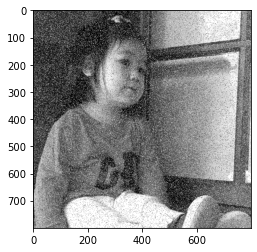

(800, 800)


In [4]:
img = cv2.imread("./Kid2 degraded.tiff", 0)
plt.imshow(img,cmap='gray')
plt.show()
print(img.shape)

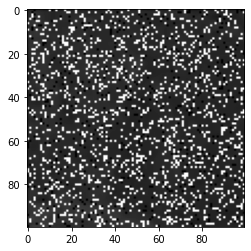

(100, 100)


In [5]:
crop_img = img[0:100,0:100]
plt.imshow(crop_img,cmap='gray')
plt.show()
print(crop_img.shape)

(256, 1)


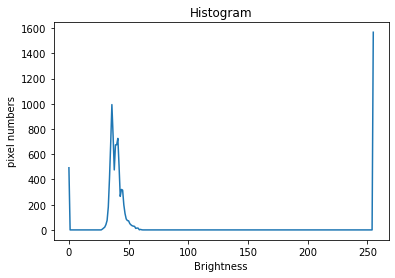

493.0
1568.0


In [6]:
hist = cv2.calcHist([crop_img], [0], None, [256], [0,256]) #cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)

print(hist.shape)

plt.title("Histogram")
plt.xlabel("Brightness")
plt.ylabel("pixel numbers")
plt.plot(hist)  
plt.show()

print(hist[0][0])
print(hist[255][0])

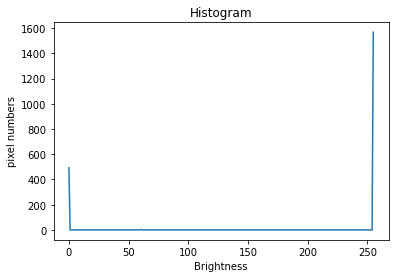

Pa=  0.0493
Pb=  0.1568


In [7]:
hist = cv2.calcHist([crop_img], [0], None, [256], [0,256]) #cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)

for i in range (40):
    hist [20+i] = 0

plt.title("Histogram")
plt.xlabel("Brightness")
plt.ylabel("pixel numbers")
plt.plot(hist)  
plt.show()

print("Pa= ",hist[0][0]/(100*100))
print("Pb= ",hist[255][0]/(100*100))

In [10]:
def AlphaTrimmedMean(data, filter_size):
    temp = []
    indexer = filter_size // 2    #2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    for i in range(len(data)):

        for j in range(len(data[0])):

            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = sum(temp[8:17])/9
            temp = []
    return data_final
  


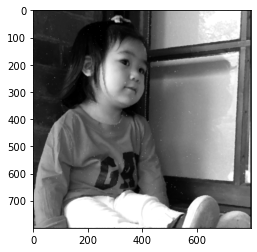

In [11]:
delnoise_img=AlphaTrimmedMean(img,5)
plt.imshow(delnoise_img,cmap='gray')
plt.show()

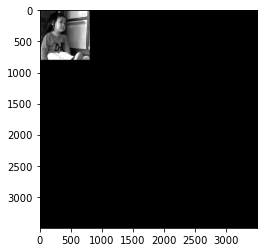

In [15]:
delnoise_img = cv2.copyMakeBorder(delnoise_img, 0, 800, 0, 800, cv2.BORDER_CONSTANT)

kid_DFT = np.fft.fft2(delnoise_img) 
kid_DFT = np.fft.fftshift(kid_DFT) 
M, N = kid_DFT.shape

plt.imshow(delnoise_img,cmap='gray')
plt.show()

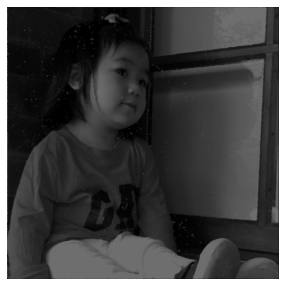

In [10]:
kid_DFT = np.fft.fft2(delnoise_img) 
kid_DFTShift = np.fft.fftshift(kid_DFT)  
M,N = kid_DFT.shape
H = np.zeros((M,N), dtype=np.float32)
D0 = 250 # cut of frequency
n = 4 # order 
for u in range(M):
    for v in range(N):
        D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
        H[u,v] = 1 / (1 + (D/D0)**n)

GLPF = np.zeros((800,800), dtype=np.float32)
D0 = 200
for u in range(800):
    for v in range(800):
        D = np.sqrt((u-800/2)**2 + (v-800/2)**2)
        GLPF[u,v] = np.exp(-D**2/(2*D0*D0))

# Gshift = kid_DFTShift * H /GLPF
Gshift = kid_DFTShift /GLPF
kid_invshift = np.fft.ifftshift(Gshift)  
kid_invDFT = np.abs(np.fft.ifft2(kid_invshift))
KID_LPF=np.uint8(cv2.normalize(kid_invDFT, None, 0, 255, cv2.NORM_MINMAX))
KID_LPF=Image.fromarray(KID_LPF)
# KID_LPF.save('KID_LPF.tif',dpi=(200.0,200.0))
plt.figure(figsize=(5,5))
plt.imshow(kid_invDFT, cmap='gray')
plt.axis('off')
plt.show()